In [1]:
import os, json
import numpy as np
import torch
from collections import OrderedDict
os.chdir('..')

from utils.visualizer import SoccerVisualizer  # same import style as eval-viz.py

# --- memmap helpers (adapted from eval-viz.py) ---
class MemmapShard:
    def __init__(self, root_dir: str, x_name: str, t_name: str, n: int, C: int, H: int, W: int):
        self.n = int(n)
        self.C, self.H, self.W = int(C), int(H), int(W)
        self.X = np.memmap(os.path.join(root_dir, x_name), mode="r", dtype=np.float16,
                           shape=(self.n, self.C, self.H, self.W))
        self.T = np.memmap(os.path.join(root_dir, t_name), mode="r", dtype=np.float32,
                           shape=(self.n, 3))

class MemmapManifest:
    def __init__(self, root_dir: str, cache_size: int = 2):
        self.root_dir = root_dir
        self.cache_size = int(cache_size)

        with open(os.path.join(root_dir, "manifest.json"), "r") as f:
            man = json.load(f)
        assert man.get("format") == "memmap_v1"

        self.C = int(man["C"]); self.H = int(man["H"]); self.W = int(man["W"])
        self.channels = list(man.get("channels", []))
        self.shards = list(man["shards"])

        self.starts = []
        cur = 0
        for s in self.shards:
            self.starts.append(cur)
            cur += int(s["n"])
        self.total = cur

        self._cache = OrderedDict()

    def _open_shard(self, shard_id: int) -> MemmapShard:
        shard_id = int(shard_id)
        if shard_id in self._cache:
            self._cache.move_to_end(shard_id)
            return self._cache[shard_id]
        s = self.shards[shard_id]
        mm = MemmapShard(self.root_dir, s["x_path"], s["t_path"], int(s["n"]), self.C, self.H, self.W)
        self._cache[shard_id] = mm
        if len(self._cache) > self.cache_size:
            self._cache.popitem(last=False)
        return mm

    def locate(self, k: int):
        k = int(k)
        lo, hi = 0, len(self.starts) - 1
        while lo <= hi:
            mid = (lo + hi) // 2
            start = self.starts[mid]
            end = self.starts[mid + 1] if mid + 1 < len(self.starts) else self.total
            if start <= k < end:
                return mid, k - start
            if k < start: hi = mid - 1
            else: lo = mid + 1
        raise RuntimeError("locate failed")

    def load_by_shard_local(self, shard_id: int, local_i: int, swap_xy: bool = False):
        shard = self._open_shard(shard_id)
        x = torch.from_numpy(np.array(shard.X[local_i], copy=True)).float()  # (C,H,W)
        t = shard.T[local_i]
        dst_xy = torch.tensor(t[:2], dtype=torch.long)
        if swap_xy:
            dst_xy = dst_xy[[1, 0]]
        y = torch.tensor(float(t[2]), dtype=torch.float32)
        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
        return x, dst_xy, y

# ---- choose dataset + load manifest once ----
DATA_ROOT = "data/finaldata-3meter"  # has train/ and val/
SPLIT = "val"                                # "train" or "val"
mm = MemmapManifest(os.path.join(DATA_ROOT, SPLIT), cache_size=2)
print(f"[data] split={SPLIT} N={mm.total} C,H,W={mm.C},{mm.H},{mm.W}")

# ---- shard selection ----
# You can lock to a specific shard_id to avoid re-opening new ones:
SHARD_ID = None  # set to int to force a specific shard
if SHARD_ID is None:
    SHARD_ID = int(np.random.randint(0, len(mm.shards)))
shard_n = int(mm.shards[SHARD_ID]["n"])
print(f"[data] using shard_id={SHARD_ID} n={shard_n}")

def sample_from_loaded_shard(local_i=None, swap_xy=False):
    if local_i is None:
        local_i = int(np.random.randint(0, shard_n))
    x_chw, dst_xy, y = mm.load_by_shard_local(SHARD_ID, local_i, swap_xy=swap_xy)
    return local_i, x_chw, dst_xy, y


[data] split=val N=7873 C,H,W=13,105,68
[data] using shard_id=0 n=7873


In [2]:
import torch
from utils.static_maps import PitchStaticChannels, PitchDims

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- static channels (same as training) ---
static = PitchStaticChannels(dims=PitchDims(H=mm.H, W=mm.W)).to(DEVICE)

# infer static channel count
with torch.no_grad():
    C_static = int(static.forward().shape[0])

C_dyn = mm.C
IN_CHANNELS = C_dyn + C_static
print(f"[static] C_dyn={C_dyn} C_static={C_static} -> in_channels={IN_CHANNELS}")

# --- model (replace with your actual constructor) ---
from models.bettermap import BetterSoccerMap2Head  # example
from models.footballmap import PassMap
from models.pitchvision import PitchVisionNet
#model = BetterSoccerMap2Head(in_channels=IN_CHANNELS, base=64, blocks_per_stage=2, dropout=0.0).to(DEVICE).float()
model = PassMap(in_channels=IN_CHANNELS, base=64, blocks_per_stage=2).to(DEVICE).float()
#model =  PitchVisionNet(C_dyn+C_static, base=96).to(DEVICE).float()
# --- checkpoint loading (adapt to your ckpt format) ---
CKPT_PATH = "training-runs/20251215-223228_PassMap/best_ckpt.pt"
ckpt = torch.load(CKPT_PATH, map_location=DEVICE,weights_only= False)
# common patterns:
if isinstance(ckpt, dict) and "model_state" in ckpt:
    sd = ckpt["model_state"]
elif isinstance(ckpt, dict) and "model" in ckpt:
    sd = ckpt["model"]
elif isinstance(ckpt, dict) and "state_dict" in ckpt:
    sd = ckpt["state_dict"]
else:
    sd = ckpt

missing, unexpected = model.load_state_dict(sd, strict=False)
print(f"[ckpt] loaded {CKPT_PATH}")
if missing: print(f"[warn] missing keys: {len(missing)}")
if unexpected: print(f"[warn] unexpected keys: {len(unexpected)}")

print(ckpt['args'])


[static] C_dyn=13 C_static=5 -> in_channels=18
[ckpt] loaded training-runs/20251215-223228_PassMap/best_ckpt.pt
[warn] unexpected keys: 80
{'data_root': 'data/finaldata-3meter/', 'cache_size': 2, 'epochs': 20, 'batch_size': 64, 'lr': 0.0003, 'wd': 0.0001, 'grad_clip': 1.0, 'seed': 42, 'num_workers': 12, 'cpu': False, 'swap_xy': False, 'w_dest': 0.0005, 'w_succ': 1.0, 'runs_dir': 'training-runs', 'save_path': 'best_ckpt.pt', 'sched': 'plateau', 'plateau_patience': 2, 'plateau_factor': 0.5, 'plateau_min_lr': 1e-06, 'plateau_threshold': 0.0001, 'viz_n': 5, 'viz_seed': 42, 'viz_every': 1}


In [3]:
import numpy as np
import torch

def compute_twohead_maps(out: dict):
    dest = out["dest_logits"]  # (B,1,H,W) or (B,H,W)
    succ = out["succ_logits"]

    if dest.dim() == 4: dest = dest[:, 0]
    if succ.dim() == 4: succ = succ[:, 0]

    B, H, W = dest.shape
    dest_probs = torch.softmax(dest.view(B, -1), dim=1).view(B, H, W)
    succ_probs = torch.sigmoid(succ)
    comp_map = dest_probs * succ_probs
    return dest_probs[0], succ_probs[0], comp_map[0]

def infer_and_plot(local_i=None, swap_xy=False, coords_are_centers=False):
    local_i, x_chw, dst_xy, y = sample_from_loaded_shard(local_i=local_i, swap_xy=swap_xy)

    # append static channels (B,C,*,*) -> (B,C+Cstatic,*,*)
    X = x_chw.unsqueeze(0).to(DEVICE)
    X = static.concat_to(X, dim=1)
    X = torch.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    with torch.no_grad():
        out = model(X)
        dest_map, succ_map, comp_map = compute_twohead_maps(out)

    # destination marker coords
    dst_x = float(dst_xy[0].item())
    dst_y = float(dst_xy[1].item())
    if not coords_are_centers:
        dst_x += 0.5
        dst_y += 0.5

    # start location from dist_to_ball argmin (channel 0 in your current schema)
    ball_dist = x_chw[0]
    flat_idx = torch.argmin(ball_dist)
    x_idx = (flat_idx // ball_dist.shape[1]).item()
    y_idx = (flat_idx %  ball_dist.shape[1]).item()
    bx, by = float(x_idx) + 0.5, float(y_idx) + 0.5

    # occupancy maps for overlay (channel 3/4 in your current schema)
    in_pos  = (x_chw[3] > 0).float()
    out_pos = (x_chw[4] > 0).float()

    vis = SoccerVisualizer(pitch_length=mm.H, pitch_width=mm.W, layout="x_rows")

    ok = "✓" if int(y.item()) == 1 else "✗"

    def _plot(heat_t: torch.Tensor, title: str):
        fig, ax, _ = vis.plot_state(
            in_possession=in_pos,
            out_possession=out_pos,
            heatmap=heat_t.detach().cpu(),
            cmap="Blues",
            heatmap_kwargs=dict(alpha=0.9),
            add_colorbar=True,
        )
        ax.scatter([bx], [by], c="black", s=30, marker="o", zorder=6, linewidths=0.5, label="Start")
        ax.scatter([dst_x], [dst_y], c="red",   s=30, marker="o", zorder=6, linewidths=0.5, label="End")
        ax.set_title(title)
        fig.tight_layout()
        fig.legend()

    _plot(dest_map, f"Destination P(dest=cell | s) | pass {ok} | local_i={local_i}")
    _plot(succ_map, f"Success P(complete | s, cell) | pass {ok} | local_i={local_i}")
    _plot(comp_map, f"Completed-pass surface P(dest & complete | s) | pass {ok} | local_i={local_i}")

    return local_i

# Run a random example from the currently loaded shard
#infer_and_plot(local_i=None)


DEST  sum/max: 0.9999999403953552 0.0034252149052917957
SUCC  sum/max: 1846.3289794921875 0.9998513460159302
PROD  sum/max: 0.3838333487510681 0.0034239748492836952


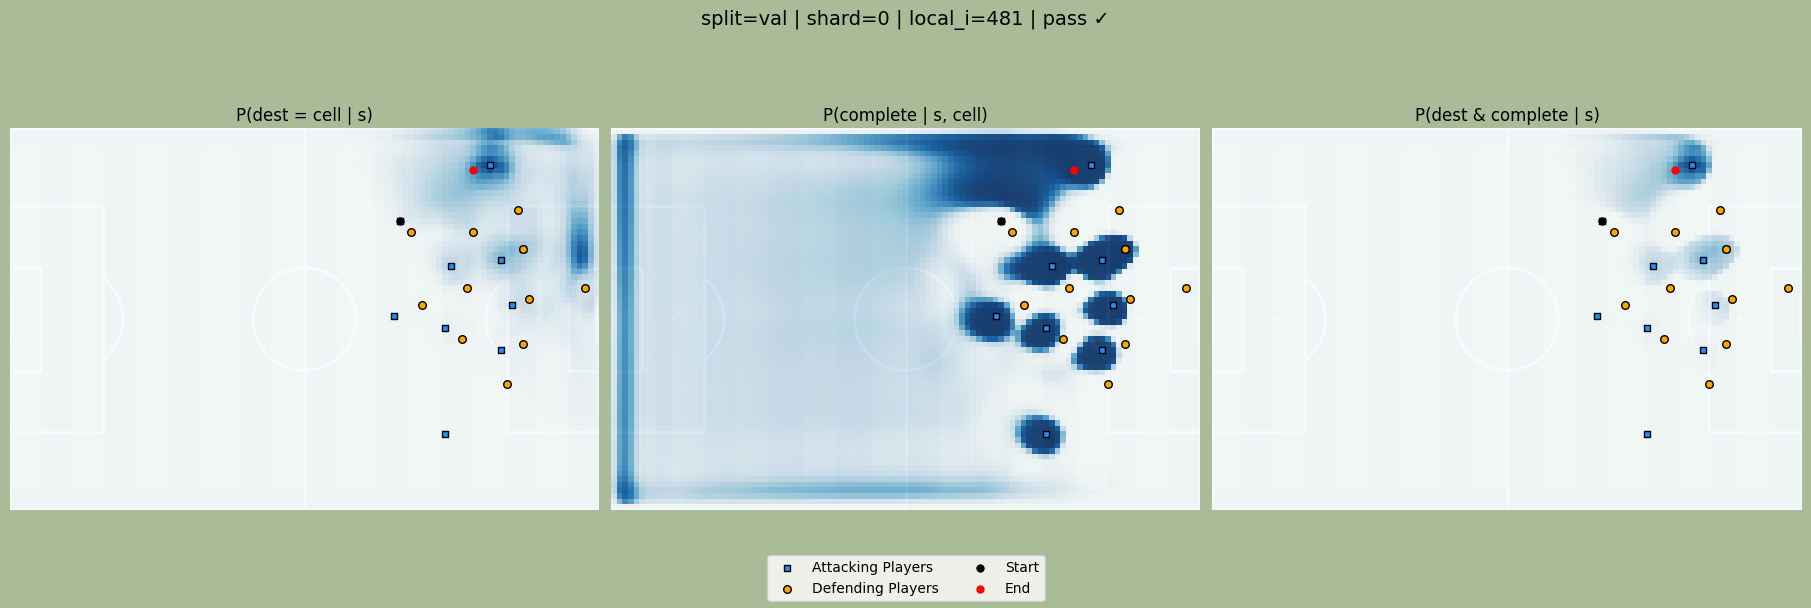

481

In [9]:
import matplotlib.pyplot as plt
import torch

def infer_and_plot_triptych(local_i=None, swap_xy=False, coords_are_centers=False):
    local_i, x_chw, dst_xy, y = sample_from_loaded_shard(local_i=local_i, swap_xy=swap_xy)

    X = x_chw.unsqueeze(0).to(DEVICE)
    X = static.concat_to(X, dim=1)
    X = torch.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    with torch.no_grad():
        out = model(X)
        dest_map, succ_map, comp_map = compute_twohead_maps(out)



    # destination marker coords
    dst_x = float(dst_xy[0].item())
    dst_y = float(dst_xy[1].item())
    if not coords_are_centers:
        dst_x += 0.5
        dst_y += 0.5

    # approximate ball location from argmin of dist_to_ball (channel 0)
    ball_dist = x_chw[0]
    flat_idx = torch.argmin(ball_dist)
    bx = float((flat_idx // ball_dist.shape[1]).item()) + 0.5
    by = float((flat_idx %  ball_dist.shape[1]).item()) + 0.5

    # overlay maps (channels 3/4 in your current schema)
    in_pos  = (x_chw[3] > 0).float()
    out_pos = (x_chw[4] > 0).float()

    vis = SoccerVisualizer(pitch_length=mm.H, pitch_width=mm.W, layout="x_rows")
    ok = "✓" if int(y.item()) == 1 else "✗"

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
    print("DEST  sum/max:", float(dest_map.sum()), float(dest_map.max()))
    print("SUCC  sum/max:", float(succ_map.sum()), float(succ_map.max()))
    print("PROD  sum/max:", float(comp_map.sum()), float(comp_map.max()))

    panels = [
        ("P(dest = cell | s)", dest_map, "Blues"),
        ("P(complete | s, cell)", succ_map, "Blues"),
        ("P(dest & complete | s)", comp_map, "Blues"),
    ]

    for ax, (title, heat, cmap) in zip(axes, panels):
        vis.plot_state(
            in_possession=in_pos,
            out_possession=out_pos,
            heatmap=heat.detach().cpu(),
            cmap=cmap,
            heatmap_kwargs=dict(alpha=0.9),
            add_colorbar=False,   # keep it clean in a 1x3
            ax=ax,
        )
        ax.scatter([bx], [by], c="black", s=25, marker="o", zorder=6, label="Start")
        ax.scatter([dst_x], [dst_y], c="red",   s=25, marker="o", zorder=6, label="End")
        ax.set_title(title, fontsize=12)

    fig.suptitle(f"split={SPLIT} | shard={SHARD_ID} | local_i={local_i} | pass {ok}", fontsize=14)
    # one shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2)

    plt.show()
    return local_i

# Run random example (same shard cached)
infer_and_plot_triptych(481)


Validation example 885 from shard 0, 762 shard 1